In [1]:
import urllib2
import numpy as np
import tarfile
import os
import gzip
import pandas as pd
import cPickle as pickle
from matplotlib.pylab import subplots
import matplotlib.pylab as mpylab
import matplotlib.ticker as mticker
import time
import datetime
import matplotlib.dates as mdates

In [2]:
def UTC_to_UnixTime(dt):
    '''
    Given a UTC time, find the Unix time

    :param dt, UTC datetime
    :type message: datetime.datetime
    :returns: Unix time of the UTC datetime, like 1200835411
    :type returns: int
    '''
    return int((dt - datetime.datetime(1970,1,1)).total_seconds())

def UnixTime_to_UTC(timestamp):

    '''
    converts Unix time to UTC time
    
    :param timestamp: unix timestamp
    :type timestamp: int 
    :return corresponding date and time
    :type: datetime.datetime
    '''
    # can show it use .strftime('%Y-%m-%d %H:%M:%S')
    return datetime.datetime.utcfromtimestamp(int(timestamp))

def find_period(UnixTime, periods):
    '''
    find the periods that UTCtime is in 
    :param UTCtime, like 1200835411
    :type message: int
    :param UTCtime, like [(start_UTCtime, end_UTCtime), ]
    :type message: int
    :returns: index of the period that UTCtime is in in periods, return -1 if cannot find a 
    period that UTCtime is in
    :type returns: int
    '''
    for i in range(len(periods)):
        if periods[i][0] <= UnixTime < periods[i][1]:
            return i
    
    # now we cannot find a period that UTCtime is in 
    return -1

def find_age_index(age, ages):
    '''
    find index of age inteval in age_intervals that the age is in 
    :param age: user age
    :type age: int 
    :param age_intervals: a list of age intervals, [(age, age), ] 
    :type age_intervals: list 
    :return index of age interval in age_intervals that age is in, return -1 if cannot find such an interval
    :type: int
    '''
    if 1 <= age <= 100:
        return age - 1
    else:
        return -1

In [3]:
path = '/Users/yjt/Downloads'
filename = 'MLHD_000.tar'
#os.chdir(path)

assert os.path.exists(path + '/' + filename) 

new_path = path + '/' + filename[:-4]
if not os.path.exists(new_path):
    os.makedirs(new_path)
tar = tarfile.open(path + '/' + filename)
tar.extractall(new_path)
tar.close()


In [4]:
for filename in os.listdir(new_path):
    if 'gz' not in filename:
        print filename

.DS_Store


In [5]:
MBID_dictionary = pickle.load(open(path + '/' + 'MBID_dictionary.p','rb'))
df_demographics = pd.read_csv(path + '/' + 'MLHD_demographics_scrobble.csv', delimiter = '\t')
df_demographics.head()

,uuid,age,country,gender,firstscrobble,lastscrobble
0,dfb7ea9d-6e4f-48e4-96f6-59abcc207d55,30.0,AT,n,1138630578,1362652343
1,a89cb9c5-ba84-424e-8950-16657bb6f7af,35.0,US,m,1130274207,1369498564
2,dde6c339-c256-43f1-94e8-02f4043abdf9,35.0,UK,m,1108340306,1357866969
3,44d70878-6e9a-432f-831d-179e8354f448,40.0,DK,n,1368342035,1126011087
4,e553ab79-5e93-48fc-aa63-1c4319cafd23,NaN,SE,n,1189263203,1357317882


In [24]:
def statistics_1(genres, periods, path):
    '''
    For several genres， count the number of listeners in different periods
    
    :param genres, a list of genres selected
    :type message: list
    :param periods, a list of periods selected, with format [(datetime, datetime), ]
    :type message: list
    :param path, a string represents path to the diretory that contains user dataset 
    :type message: str
    :returns: a dictionary contains all the statistics information, with format 
    {genres: (periods, #listeners)}
    :type returns: dict
    
    Global variable df_demographics and MBID_dictionary are used
    '''
    
    # dictionaries: {genres: (periods, #listeners)} 
    # initialization of dictionary
    statistics = {}
    for genre in genres:
        statistics[genre] = (periods, [0] * len(periods))
    
    for filename in os.listdir(path): # iterate over all user files
        # user file has file name: uuid.txt.gz
        if 'gz' in filename:
            with gzip.open(new_path + '/' + filename) as f:
                # clearing the data
                user = pd.read_csv(f, delimiter = '\t', header = None)
                user = user.drop([2,3],axis=1) 
                user = user.dropna()
                user.columns = ['time', 'artist_MBID']

                # one user can only be counted once for one period of every genre
                # so we use tag_added to denote whether one user is added as a listener
                # for a genre of some period 
                # tag_added has format {genre: list of booleans, }
                # tag_added[genre][i] == True indicates that this user has been added as 
                # a listener for genre for periods[i]. False indicates hasn't been added.
                # initialization
                tag_added = {}
                for genre in genres:
                    tag_added[genre] =  [False] * len(periods)

                # user_used is a boolean indicating whether we use this user to do statistics
                # because the data of user is obtained in different time periods, so we need to
                # ensure that in the periods we used to do statistics, the user is continuing to
                # contribute data to our dataset
                user_uuid = filename[:-7]
                user_demographics = df_demographics[df_demographics.uuid == user_uuid]
                user_used = False
                if user_demographics.shape[0] > 0: # if the user has demographics
                    user_used = user_demographics.iat[0,4] <= periods[0][0] \
                        and user_demographics.iat[0,5] >= periods[len(periods) - 1][1]


                for i in range(user.shape[0]): #iterate all logs in one user file
                    if user_used:
                        period_index = find_period(user.iat[i,0], periods)
                        if  period_index != -1:
                            if user.iat[i,1] in MBID_dictionary:
                                taglist = MBID_dictionary[user.iat[i,1]]
                                for tag in taglist: 
                                    for genre in genres:
                                        # tag can be something like 'hardrock' and 'pop/rock'
                                        if genre in tag and not tag_added[genre][period_index]:
                                            statistics[genre][1][period_index] += 1
                                            tag_added[genre][period_index] = True
    return statistics

In [7]:
def plot_graph1(statistics, datemin, datemax):
    '''
    User statistical information produced in statistics_1(genres, periods, path) 
    and plot correspoding graph, for several genres，the number of listeners vs time period
    
    :param statistics, the output of statistics_1(genres, periods, path), a dictionary of
    format: {genres: (periods, #listeners)}
    :type statistics: dict
    :param datemin, the small bound of x we plot
    :type message: datetime.datetime
    :param datemax, the large bound of x we plot
    :type message: datetime.datetime
    :returns: no return
    
    '''
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    fig,ax = subplots()
    for genre in iter(statistics):
        dates = [UnixTime_to_UTC(period[0]) for period in statistics[genre][0]]
        ax.plot(dates,statistics[genre][1], label = genre)


    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlabel('date')
    ax.set_ylabel('number of listeners')
    ax.set_title('number of listeners vs date for different genres', fontsize=14)

    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    ax.set_xlim(datemin, datemax)
    ax.grid(True)
    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()

    fig.show()
    mpylab.savefig('1_(%d,%d).png' %(datemin.year,datemax.year), bbox_inches='tight')
    
    return
    

In [8]:
def statistics_3(genres, ages, path, start_UnixTime, end_UnixTime):
    '''
    In some time period, for several genres， count the number of listeners of different ages
    
    :param genres, a list of genres selected
    :type message: list
    :param ages, a list of ages selected, with format [age, ]
    :type message: list
    :param path, a string represents path to the diretory that contains user dataset 
    :type message: str
    :param start_UnixTime, the unix time of start of period we used
    :type message: int
    :param end_UnixTime, the unix time of end of period we used 
    :type message: int
    :returns: a dictionary contains all the statistics information, with format 
    {genres: (ages, #listeners)}
    :type returns: dict
    
    Global variable df_demographics and MBID_dictionary are used
    '''
    
    # data format, dictionaries: {genres: (ages, #listeners)} 
    # initialization of dictionary
    statistics = {}
    for genre in genres:
        statistics[genre] = (ages, [0] * len(ages))
    
    # number of files we go through
    for filename in os.listdir(path): # iterate over all user files
        # user file has file name: uuid.txt.gz
        if 'gz' in filename:
            with gzip.open(new_path + '/' + filename) as f:
                # clearing the data
                user = pd.read_csv(f, delimiter = '\t', header = None)
                user = user.drop([2,3],axis=1) 
                user = user.dropna()
                user.columns = ['time', 'artist_MBID']



                # graph 3
                # one user can only be counted once for one age of every genre
                # so we use tag_added to denote whether one user is added as a listener
                # for a genre of some period 
                # tag_added initialization
                tag_added = {}
                for genre in genres:
                    tag_added[genre] =  [False] * len(ages)
                    
                user_uuid = filename[:-7]
                user_demographics = df_demographics[df_demographics.uuid == user_uuid]
                user_demographics_dropna = user_demographics.dropna()

                for i in range(user.shape[0]): #iterate all logs in one user file
                    # only use data in [start_UnixTime, end_UnixTime] period
                    if start_UnixTime <= user.iat[i,0] <= end_UnixTime:
                        if user_demographics_dropna.shape[0] > 0:
                            user_age = int(user_demographics_dropna.iat[0,1] \
                                           - UnixTime_to_UTC(user_demographics_dropna.iat[0,4]).year \
                                           + UnixTime_to_UTC(user.iat[i,0]).year)
                        else:
                            # case that we cannot extract the user's age
                            user_age = -1

                        age_index = find_age_index(user_age, ages)
                        if age_index != -1:
                            if user.iat[i,1] in MBID_dictionary:
                                taglist = MBID_dictionary[user.iat[i,1]]
                                for tag in taglist: 
                                    for genre in genres:
                                        # tag can be something like 'hardrock' and 'pop/rock'
                                        if genre in tag and not tag_added[genre][age_index]:
                                            statistics[genre][1][age_index] += 1
                                            tag_added[genre][age_index] = True
    
    return statistics

In [9]:
def plot_graph3(statistics, agemin=0, agemax=100):
    '''
    User statistical information produced in statistics_3(genres, ages, path, start_UnixTime, end_UnixTime) 
    and plot correspoding graph, for several genres，the number of listeners vs age
    
    :param statistics, the output of statistics_3(genres, ages, path, start_UnixTime, end_UnixTime), 
    a dictionary of format: {genres: (ages, #listeners)}
    :type statistics: dict
    :param agemin, the small bound of x we plot
    :type message: int
    :param agemax, the large bound of x we plot
    :type message: int
    :returns: no return
    
    '''
    
    fig,ax = subplots()
    for genre in iter(statistics):
        ax.plot(statistics[genre][0], statistics[genre][1], label = genre)


    ax.legend(loc='best')
    ax.set_xlabel('age')
    ax.set_ylabel('number of listeners')
    ax.set_title('number of listeners vs age for different genres',fontsize=14)
    ax.set_xlim(agemin, agemax)

    # format the ticks
    ax.xaxis.set_major_locator(mticker.IndexLocator(5, -1))
    ax.xaxis.set_minor_locator(mticker.IndexLocator(1, 1))
    #ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    fig.show()

    #for genre in iter(statistics3):
        #print statistics3[genre][1]

    mpylab.savefig('3_(%d, %d).png' %(agemin, agemax), bbox_inches='tight')

    return

In [25]:
# graph1
# periods = [(start_UnixTime, end_UnixTime), ]
# the whole period is selected empirically
# we user one month as the time period

# first select point-in-time and transfer them to unix times
selected_datetimes = []
for i in range(5):
    for j in range(12):
        selected_datetimes.append(datetime.datetime(2008 + i, j + 1, 1))
UnixTimes = [UTC_to_UnixTime(dt) for dt in selected_datetimes]

# then form periods
periods = []
for i in range(len(UnixTimes) - 1):
    periods.append((UnixTimes[i], UnixTimes[i + 1])) 
    
genres = ['pop', 'rock', 'jazz', 'folk', 'blue', 'kpop', 'hiphop', 'disco'] # list of genres
path = '/Users/yjt/Downloads/MLHD_000'

start_time = time.time()
statistics1 = statistics_1(genres, periods, path)
print("--- %s seconds ---" % (time.time() - start_time)) 


--- 974.032544851 seconds ---


In [16]:
%matplotlib inline

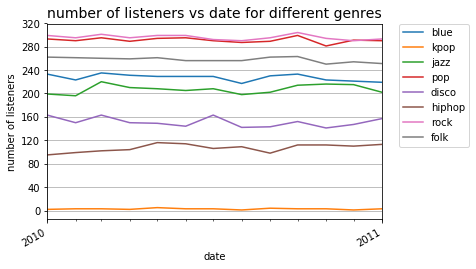

In [27]:
datemin = datetime.datetime(2010, 1, 1)
datemax = datetime.datetime(2011, 1, 1)
plot_graph1(statistics1, datemin, datemax)

In [34]:
# graph 3
# ages = [1, 2, 3,..., 100]
ages = [i + 1 for i in range(100)]
    
# we only use data of some period from start_UnixTime to end_UnixTime
start_datetime = datetime.datetime(2009,1,1)
end_datetime = datetime.datetime(2012,1,1)
start_UnixTime = UTC_to_UnixTime(start_datetime)
end_UnixTime = UTC_to_UnixTime(end_datetime)

genres = ['pop', 'rock', 'jazz', 'folk', 'blue', 'kpop', 'hiphop', 'disco'] # list of genres
path = '/Users/yjt/Downloads/MLHD_000'

start_time = time.time()
statistics3 = statistics_3(genres, ages, path, start_UnixTime, end_UnixTime)
print("--- %s seconds ---" % (time.time() - start_time)) 


--- 1485.69580507 seconds ---


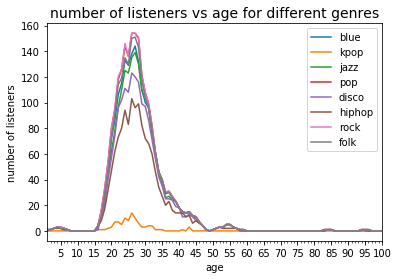

In [39]:
# plot graph 3
agemin = 1
agemax = 100
plot_graph3(statistics3,agemin,agemax)

In [32]:
def statistics_5(genres, periods, path):
    '''
    For several genres， count the number of artists working on this genre in different periods
    
    :param genres, a list of genres selected
    :type message: list
    :param periods, a list of periods selected, with format [(datetime, datetime), ]
    :type message: list
    :param path, a string represents path to the diretory that contains user dataset 
    :type message: str
    :returns: a dictionary contains all the statistics information, with format 
    {genres: (periods, #artists)}
    :type returns: dict
    
    Global variable df_demographics and MBID_dictionary are used
    '''
    
    # data format, dictionaries: {genres: (periods, #artists)} 
    # initialization of dictionary
    statistics = {}
    for genre in genres:
        statistics[genre] = (periods, [0] * len(periods))
        
    # one artist can only be counted once for one period of every genre
    # so we use tag_added to denote whether one user is added as a listener
    # for a genre of some period 
    # tag_added has format: {genre:{artist_MBID: list of booleans}, }
    # tag_added[genre][artis_MBID][i] == True indicates that artist indentified by
    # artist_MBID has been added as an artist for genre for periods[i]. 
    # False indicates hasn't been added.
    # tag_added initialization
    tag_added = {}
    for genre in genres:
        tag_added[genre] = {}

    # number of files we go through
    for filename in os.listdir(new_path): # iterate over all user files
        # user file has file name: uuid.txt.gz
        if 'gz' in filename:
            with gzip.open(new_path + '/' + filename) as f:
                # clearing the data
                user = pd.read_csv(f, delimiter = '\t', header = None)
                user = user.drop([2,3],axis=1) 
                user = user.dropna()
                user.columns = ['time', 'artist_MBID']

                # user_used is a boolean indicating whether we use this user to do statistics
                # because the data of user is obtained in different time periods, so we need to
                # ensure that in the periods we used to do statistics, the user is continuing to
                # contribute data to our dataset
                user_uuid = filename[:-7]
                user_demographics = df_demographics[df_demographics.uuid == user_uuid]
                user_used = False
                if user_demographics.shape[0] > 0: # if the user has demographics
                    user_used = user_demographics.iat[0,4] <= periods[0][0] \
                        and user_demographics.iat[0,5] >= periods[len(periods) - 1][1]

                for i in range(user.shape[0]): #iterate all logs in one user file
                    if user_used:
                        period_index = find_period(user.iat[i,0], periods)
                        if  period_index != -1:
                            if user.iat[i,1] in MBID_dictionary:
                                taglist = MBID_dictionary[user.iat[i,1]]
                                for tag in taglist: 
                                    for genre in genres:
                                        # tag can be something like 'hardrock' and 'pop/rock'
                                        if genre in tag:
                                            if user.iat[i,1] not in tag_added[genre]:
                                                tag_added[genre][user.iat[i,1]] = [False] * len(periods)
                                                tag_added[genre][user.iat[i,1]][period_index] = True
                                                statistics[genre][1][period_index] += 1
                                            else:
                                                if not tag_added[genre][user.iat[i,1]][period_index]:
                                                    tag_added[genre][user.iat[i,1]][period_index] = True
                                                    statistics[genre][1][period_index] += 1
    return statistics
    

In [20]:
def plot_graph5(statistics, datemin, datemax):
    '''
    User statistical information produced in statistics_5(genres, periods, path) 
    and plot correspoding graph, for several genres，the number of artists vs period
    
    :param statistics, the output of statistics_5(genres, periods, path), a dictionary of
    format: {genres: (periods, #artists)}
    :type statistics: dict
    :param datemin, the small bound of x we plot
    :type message: datetime.datetime
    :param datemax, the large bound of x we plot
    :type message: datetime.datetime
    :returns: no return
    
    '''
    
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    
    fig,ax = subplots()
    for genre in iter(statistics):
        dates = [UnixTime_to_UTC(period[0]) for period in statistics[genre][0]]
        ax.plot(dates,statistics[genre][1], label = genre)


    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlabel('date')
    ax.set_ylabel('number of artists')
    ax.set_title('number of artists vs date for different genres', fontsize=14)
    ax.set_xlim(datemin, datemax)

    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()

    fig.show()
    mpylab.savefig('5_(%d,%d).png' %(datemin.year,datemax.year), bbox_inches='tight')
    #print statistics5['pop']
    

In [33]:
# graph5
# periods = [(start_UnixTime, end_UnixTime)]
# the whole period is selected empirically
# we user one month as the time period

# first select point-in-time and transfer them to unix times
selected_datetimes_5 = []
for i in range(5):
    for j in range(12):
        selected_datetimes_5.append(datetime.datetime(2008 + i, j + 1, 1))
UnixTimes_5 = [UTC_to_UnixTime(dt) for dt in selected_datetimes_5]

# then form periods
periods_5 = []
for i in range(len(UnixTimes_5) - 1):
    periods_5.append((UnixTimes_5[i], UnixTimes_5[i + 1])) 
    
genres = ['pop', 'rock', 'jazz', 'folk', 'blue', 'kpop', 'hiphop', 'disco'] # list of genres
path = '/Users/yjt/Downloads/MLHD_000'

start_time = time.time()
statistics5 = statistics_5(genres, periods_5, path)
print("--- %s seconds ---" % (time.time() - start_time))


--- 1567.45553303 seconds ---


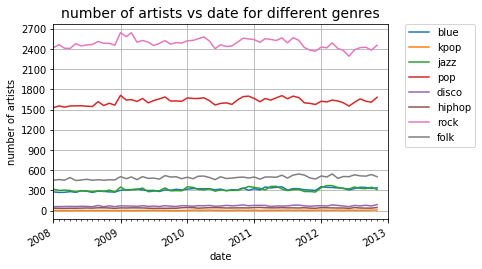

In [36]:
datemin = datetime.datetime(2008, 1, 1)
datemax = datetime.datetime(2013, 1, 1)
plot_graph5(statistics5, datemin, datemax)